In [1]:
suppressPackageStartupMessages({
library(tidyverse)
library(magrittr)
library(here)
library(furrr)
library(scales)
library(lemon)
library(cowplot)

devtools::load_all(".")
})

plan(multiprocess, workers = 30)

Loading ychr


I've started with the strictest possible "genotyping" of the Y chromosome - requiring a perfect consensus of all alleles at a site.

This procedure is of course perfectly fine and conservative, but it removes a lot of sites.

It's better to introduce some reasonable tolerance, to allow for a bit of error/contamination/damage, assuming the proportion of such false alleles is minor.

One simple way to do this is to require a perfect consensus if the number of observed alleles is rather small (such as 4), but allow some tolerance for sites with more alleles. Because the higher the coverage, the higher the probability of observing at least some error.

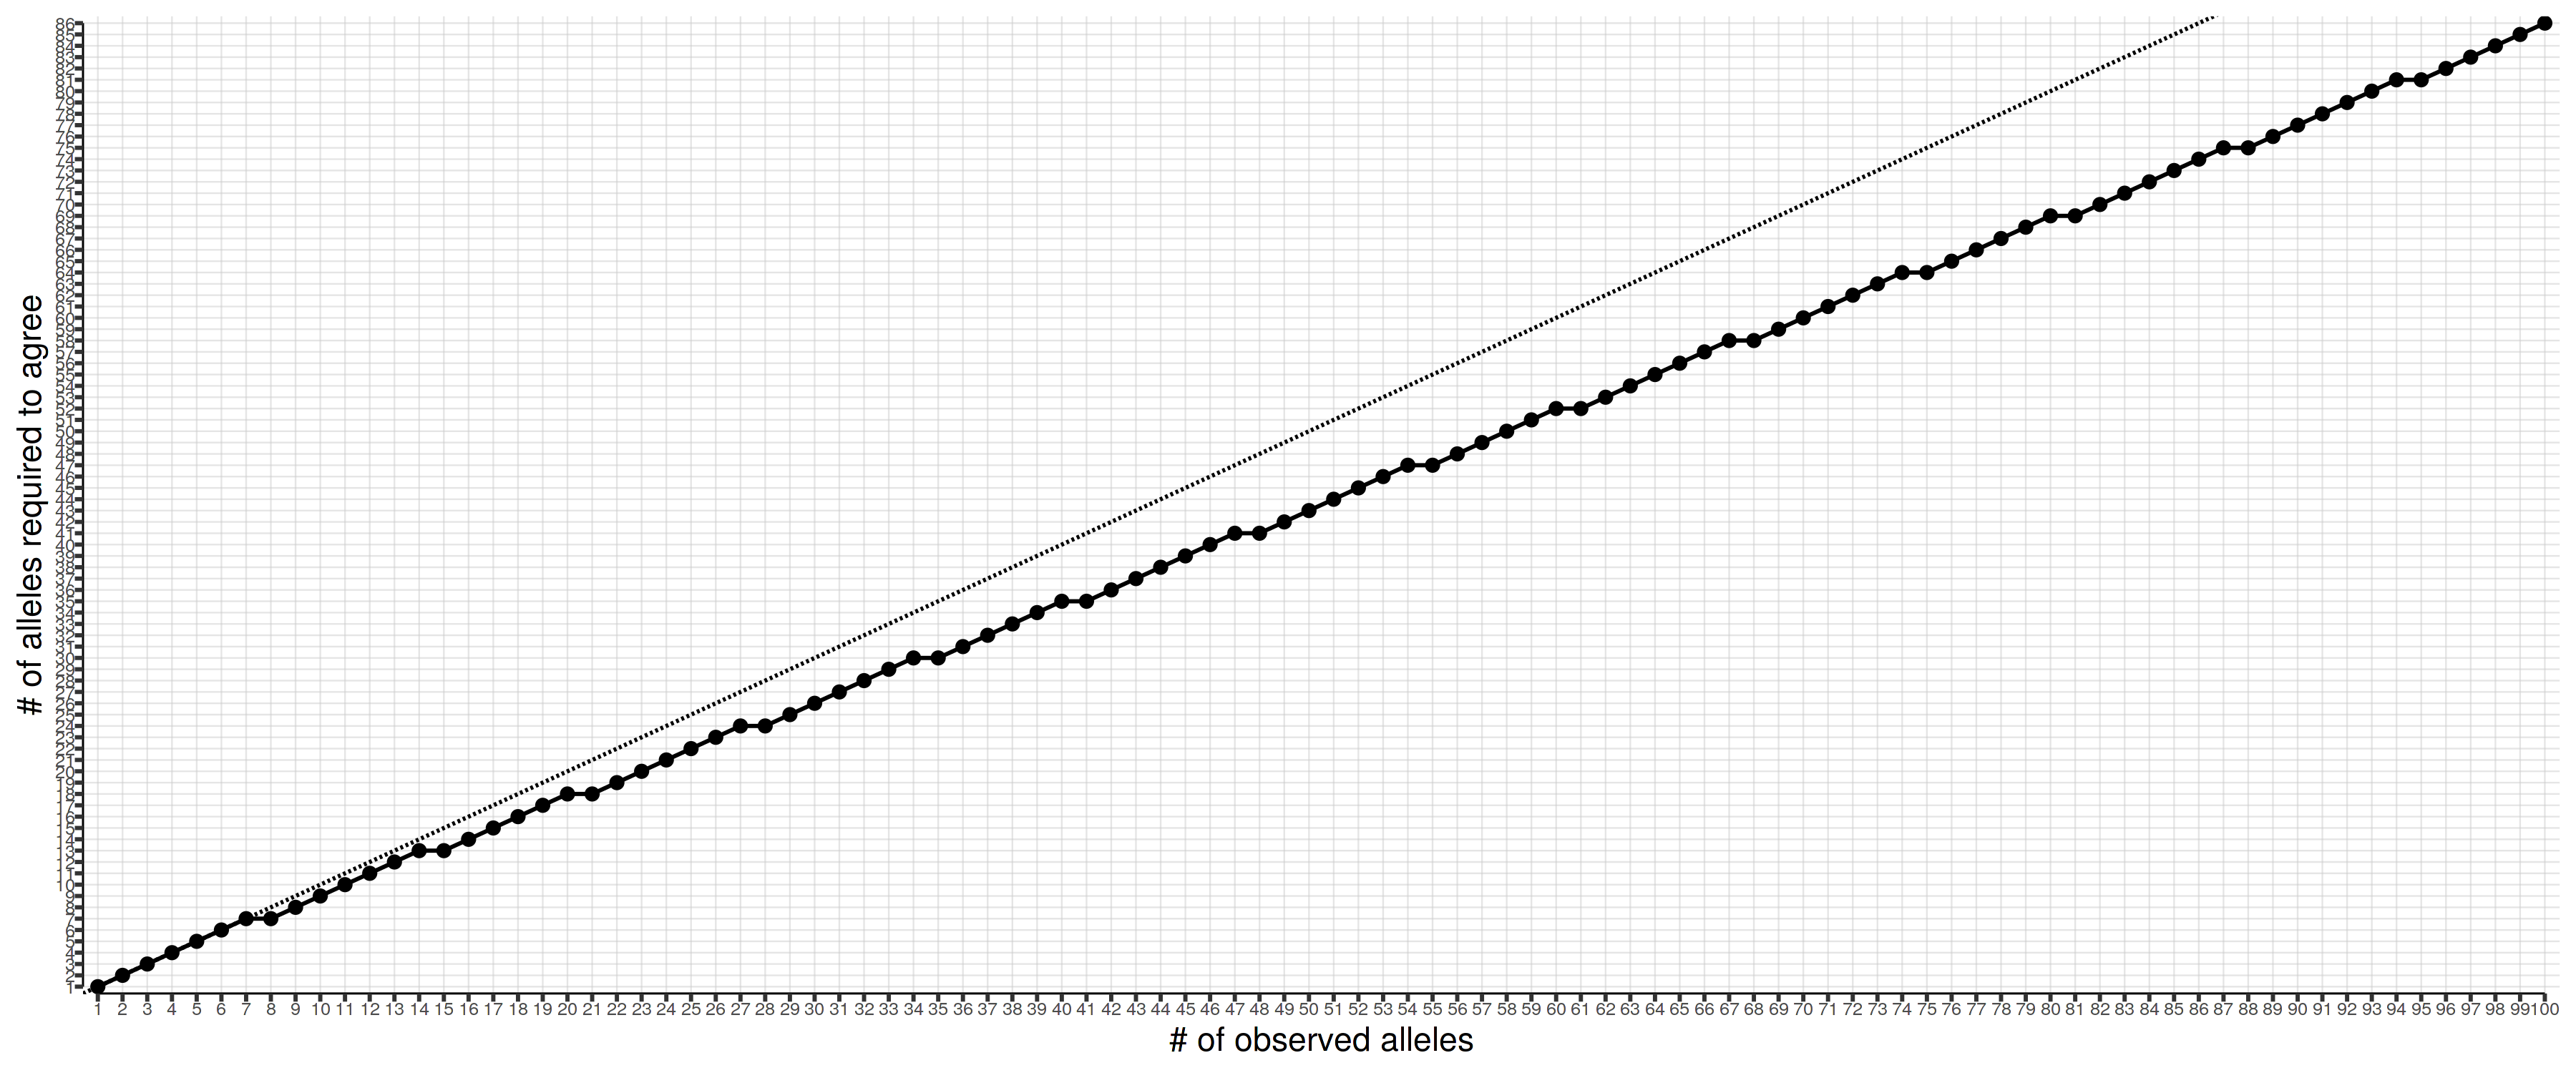

In [73]:
tolerance <- 0.15
n <- 100

df <- data.frame(
    x = factor(1:n, levels = 1:n),
    y = factor(1:n - trunc((1:n - 1) * tolerance), levels = 1:n)
)

ggplot(df, aes(x, y)) +
    geom_point() +
    geom_line(group = 1) +
    geom_abline(slope = 1, linetype = 2) +
    xlab("# of observed alleles") + ylab("# of alleles required to agree") +
    theme_bw() +
    theme(
        panel.border=element_blank(), 
        strip.text.x = element_text(size = 10),
        strip.background = element_blank(),
        axis.line = element_line(size = 1/4),
        legend.position = "right",
        axis.text = element_text(size = 6)
    ) +
    background_grid(major = "xy", minor = "xy", size.major = 0.2, size.minor = 0.2,
                    color.major = rgb(0.8, 0.8, 0.8, alpha = 0.5),
                    color.minor = rgb(0.8, 0.8, 0.8, alpha = 0.5)) +
    coord_capped_cart(bottom = "both", left = "both")

In [3]:
highcov_gt <- read_vcf(here("data/vcf/full_highcov.vcf.gz"), mindp = 3, maxdp = 0.98)

In [4]:
step1 <- run_step1(highcov_gt)

In [6]:
step1 %>% summarise_if(is.numeric, mean)

a,b,c,d,e,f,total,mut_rate,tmrca_afr
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
976,1.153846,7.615385,198.4615,11.84615,1002.846,5785339,7.167508e-10,243052.2


In [11]:
tmrca_df <- map_dfr(c("mez2"), function(arch) {
    map_dfr(c("all", "tv_only"), function(sites) {
        future_map_dfr(sprintf("%.2f", seq(0, 0.5, 0.01)), function(tol) {
            paste0("tolerance_", tol) %>%
                read_genotypes("test", mindp = 3, maxdp = 0.98, tv_only = (sites == "tv_only"),
                           bed_filter = "/mnt/454/HighCovNeandertalGenome/Hengs_Alignability_Filter/hs37m_filt35_50.bed.gz") %>%
                run_step2(step1) %>%
                mutate(tol = tol, sites = sites)
        })
    })
})

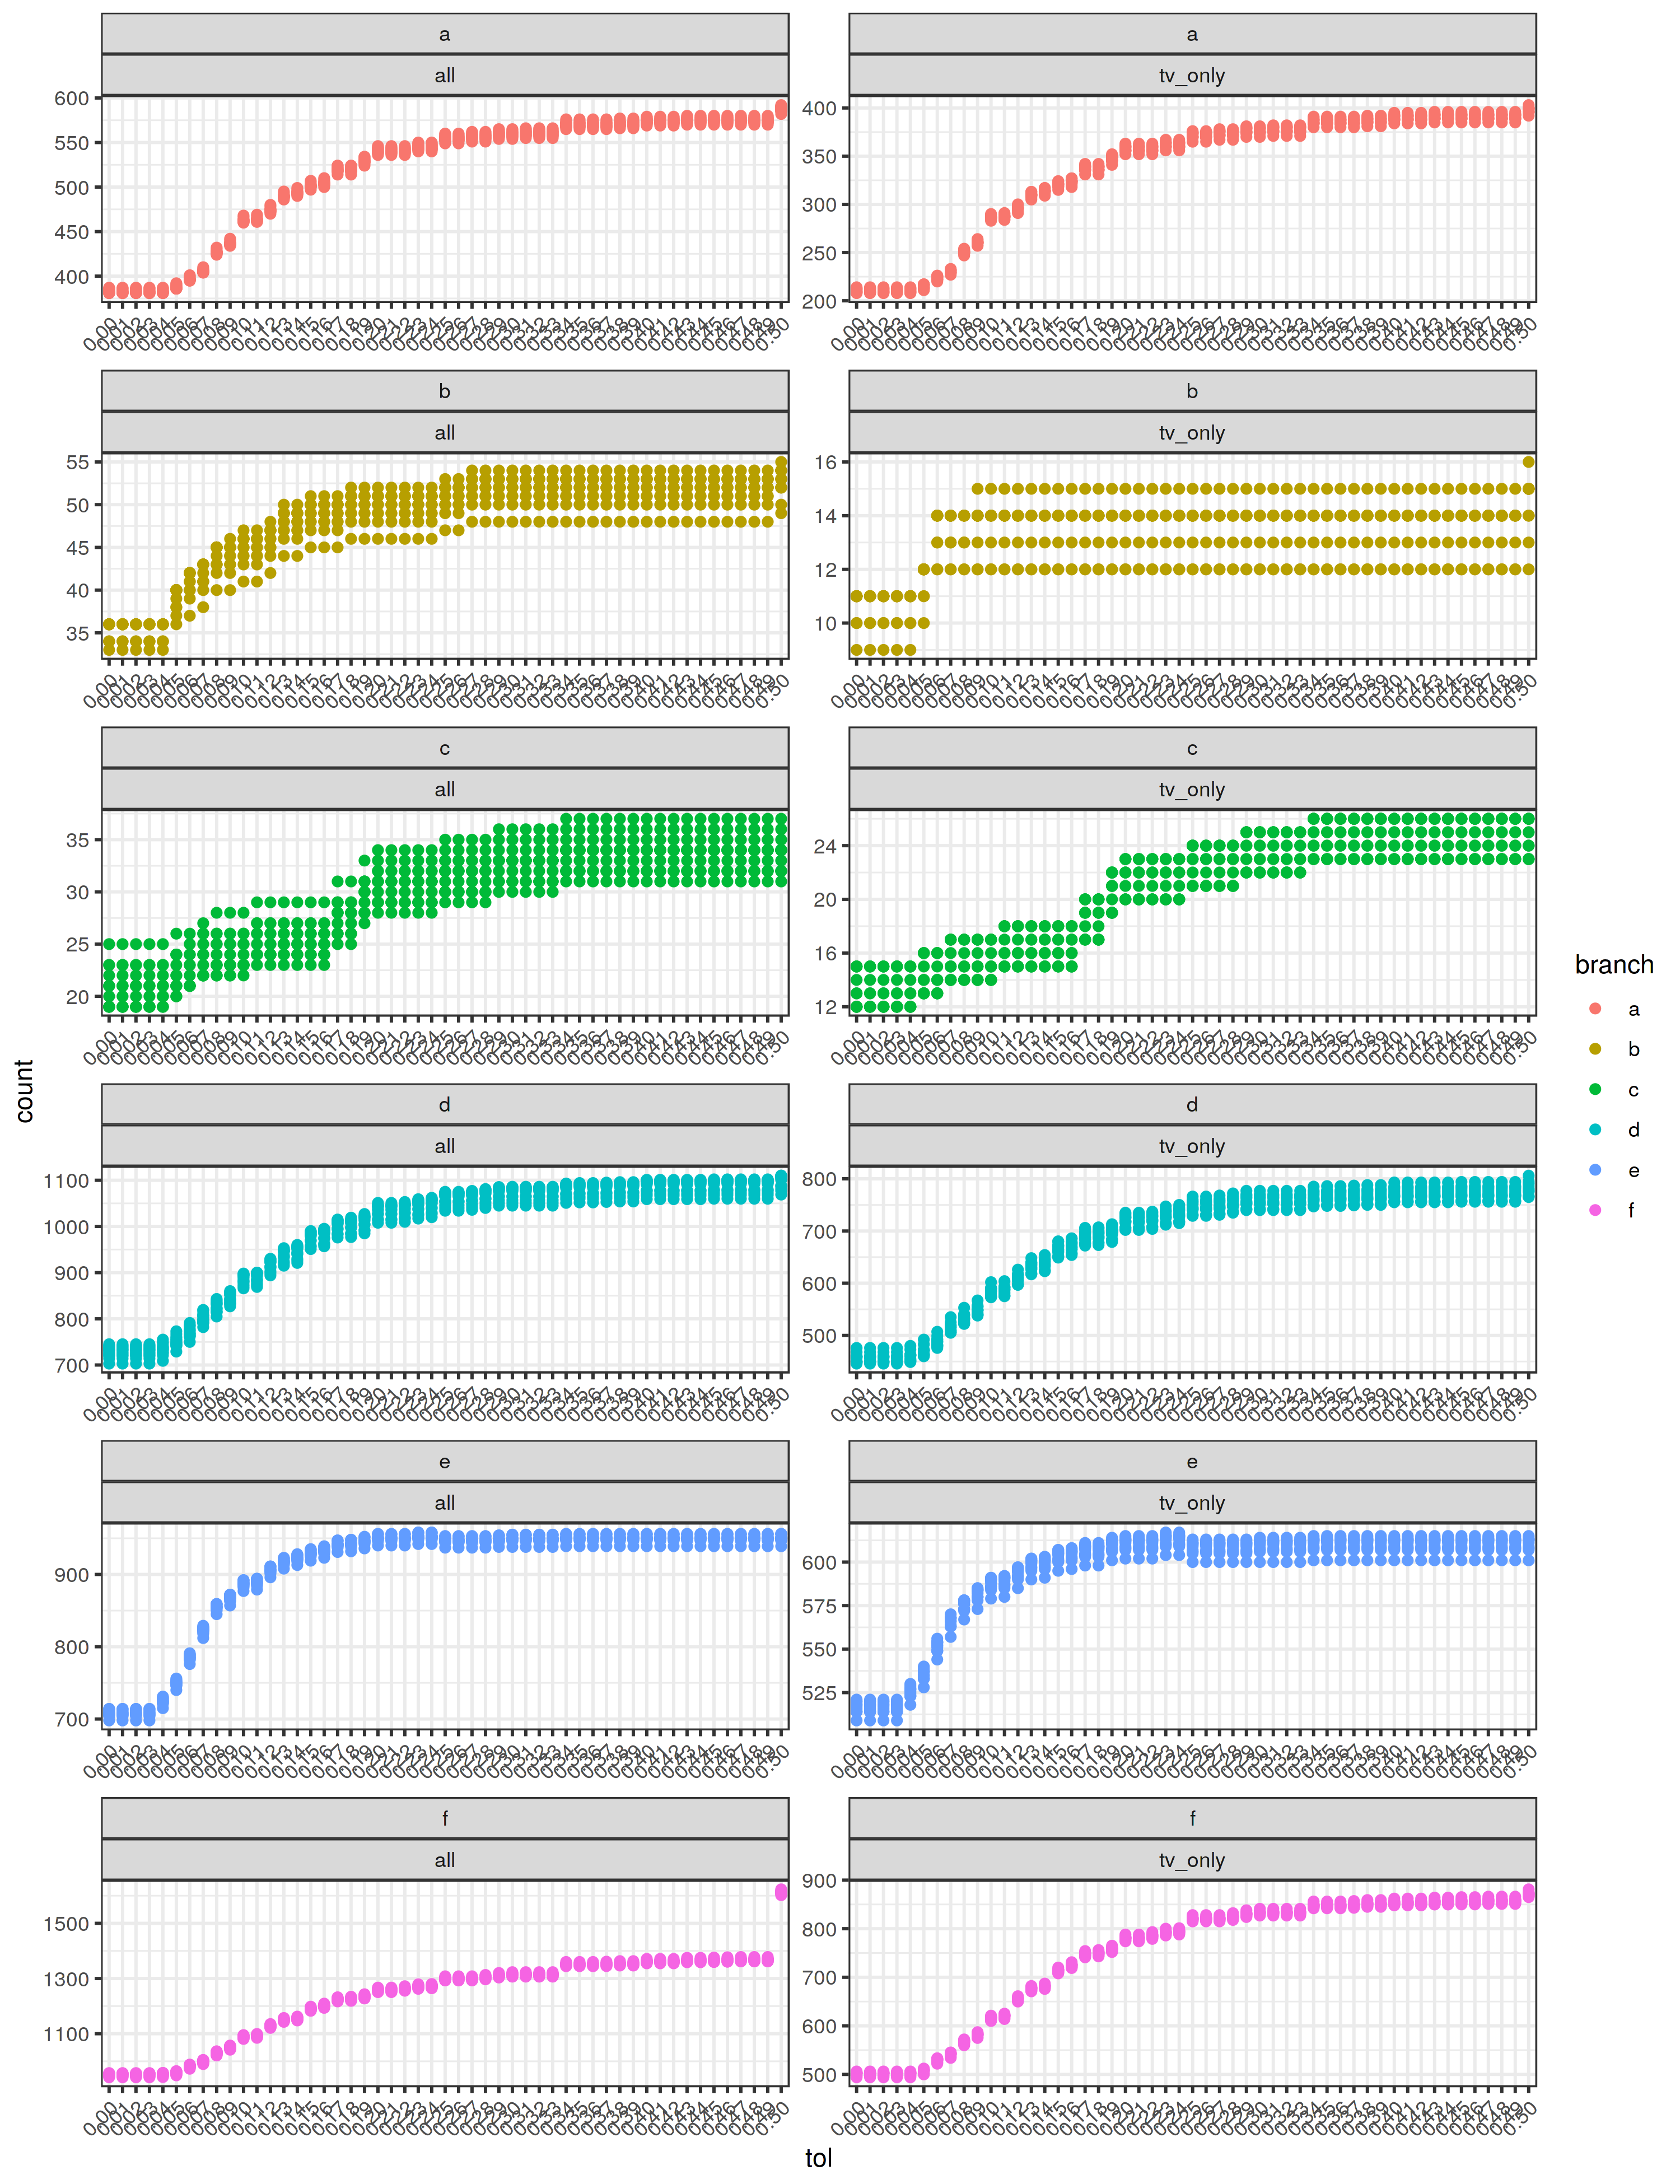

In [52]:
set_dim(10, 13)

tmrca_df %>%
select(-c(total, mut_rate, tmrca_afr, tmrca_mendez, tmrca_new)) %>%
mutate(n_muts = a + b + c + d + e + f) %>%
gather(branch, count, -c(n_muts, arch, afr, ref, tol, sites)) %>%
mutate(prop = count / n_muts) %>%
ggplot(aes(tol, count, color = branch)) +
    geom_point() +
    theme_bw() +
    theme(axis.text.x = element_text(hjust = 1, angle = 45)) +
    facet_wrap(branch ~ sites, scales = "free", ncol = 2)

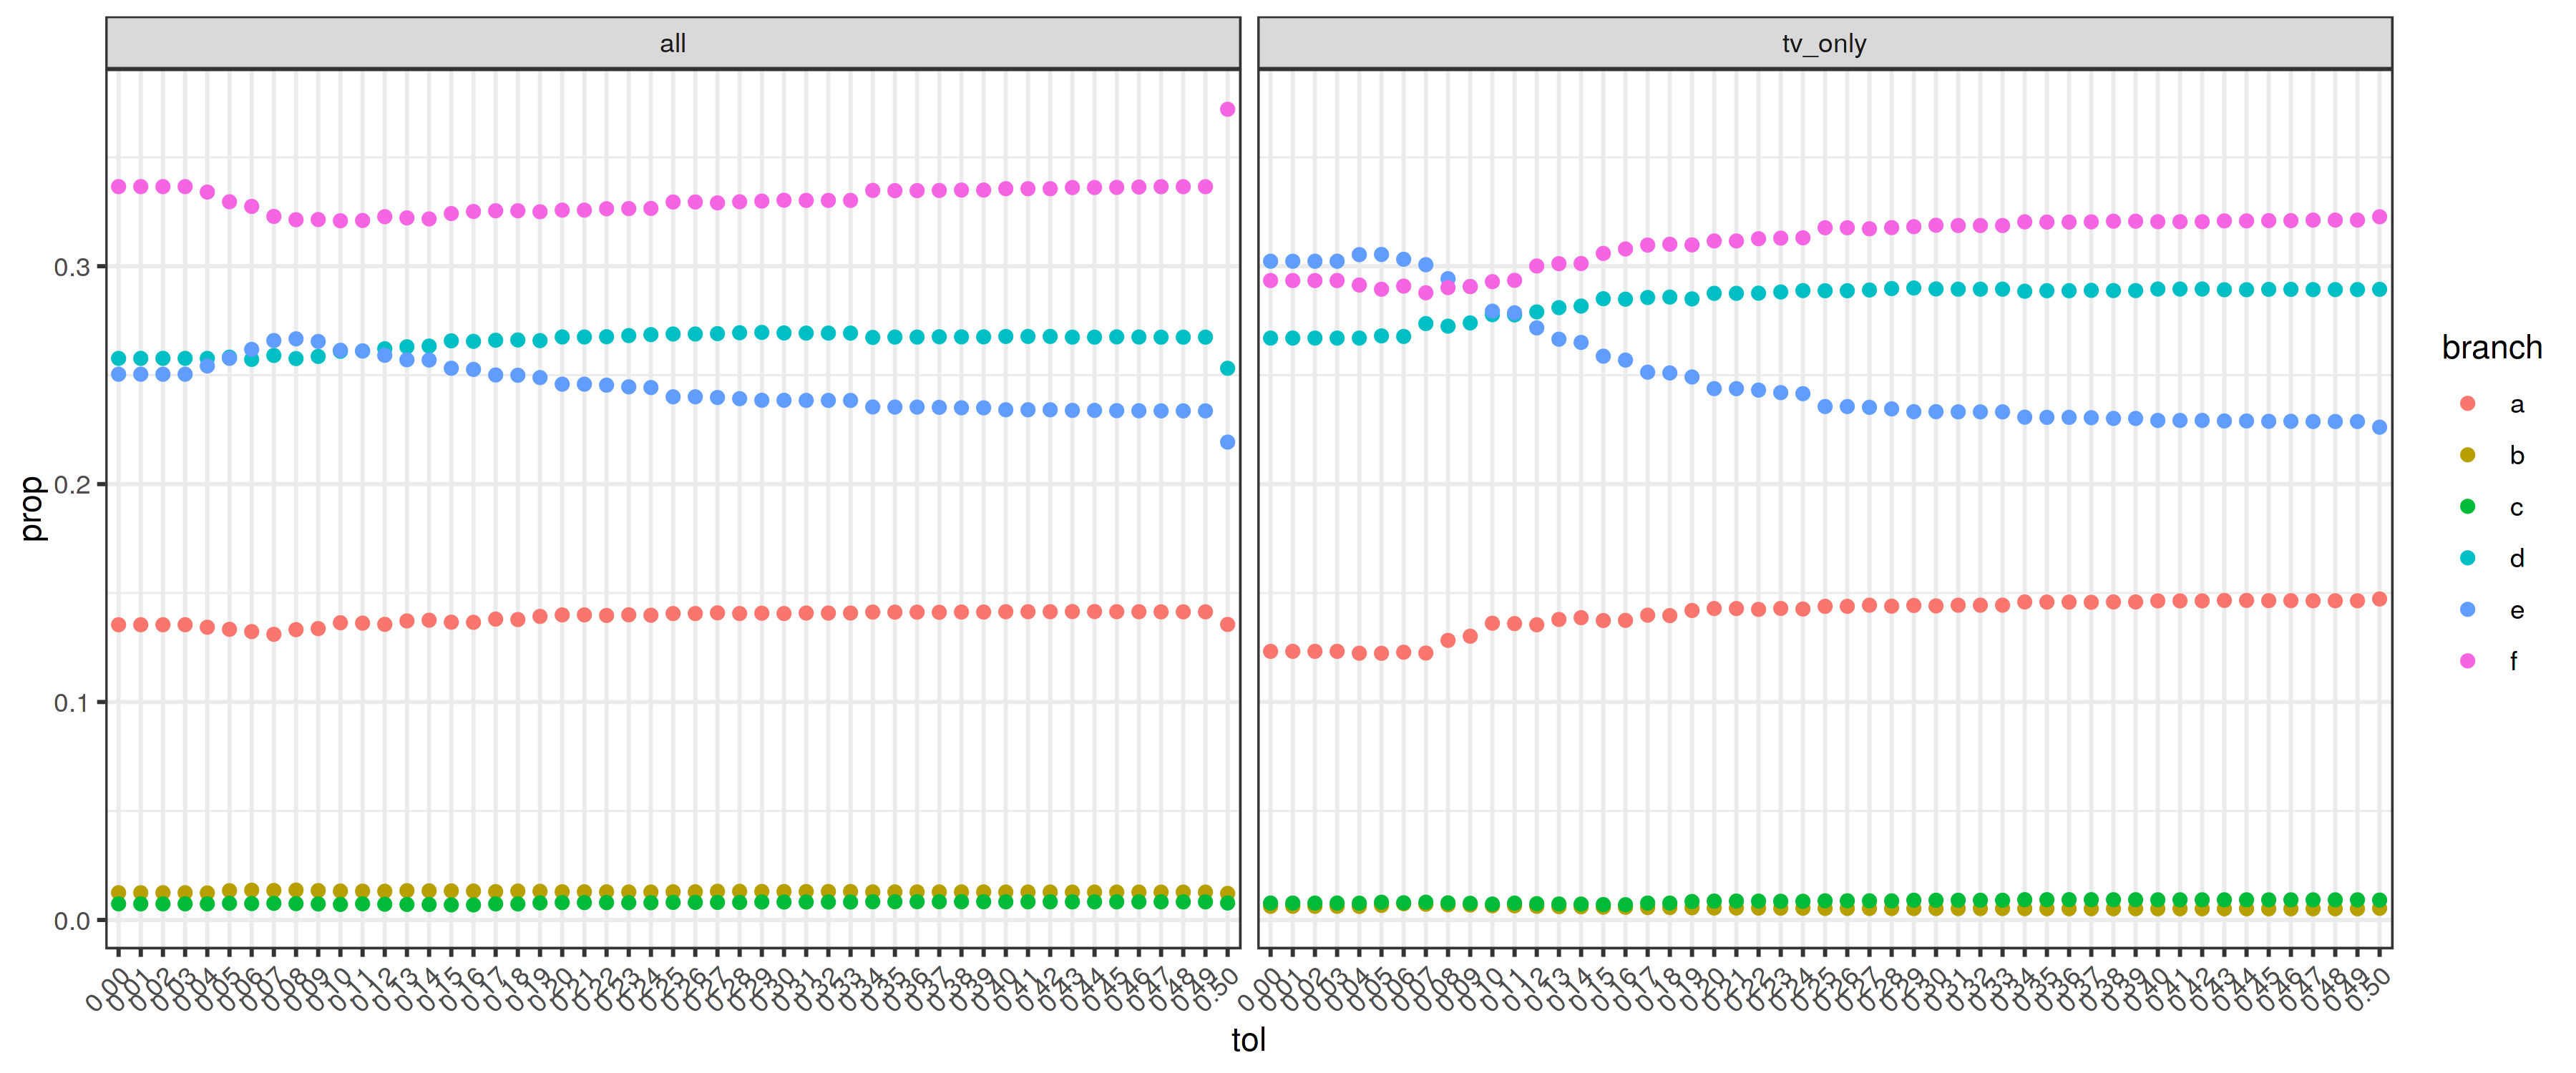

In [65]:
set_dim(12, 5)

tmrca_df %>%
select(-c(total, mut_rate, tmrca_afr, tmrca_mendez, tmrca_new)) %>%
mutate(n_muts = a + b + c + d + e + f) %>%
gather(branch, count, -c(n_muts, arch, afr, ref, tol, sites)) %>%
mutate(prop = count / n_muts) %>%
group_by(arch, afr, branch, sites, tol) %>%
summarise_if(is.numeric, mean) %>%
ggplot(aes(tol, prop, color = branch)) +
    geom_point() +
    theme_bw() +
    theme(axis.text.x = element_text(hjust = 1, angle = 45)) +
    facet_wrap(~ sites)